In [1]:
# 📌 1. Importar librerías principales
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
# Configuraciones generales
sns.set(style="whitegrid")
pd.set_option("display.max_columns", None)


In [18]:
# 📌 2. Cargar el archivo tratado de la Parte 1
df = pd.read_csv("/content/telecom_clientes_tratado.csv")

# Fill missing values in 'Charges.Total' with the mean
df['Charges.Total'].fillna(df['Charges.Total'].mean(), inplace=True)

df.head()

/tmp/ipython-input-3090685212.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Charges.Total'].fillna(df['Charges.Total'].mean(), inplace=True)


,customerID,Churn,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,Charges.Monthly,Charges.Total
0,0002-ORFBO,No,Female,0,Yes,Yes,9,Yes,No,DSL,No,Yes,No,Yes,Yes,No,One year,Yes,Mailed check,65.6,593.30
1,0003-MKNFE,No,Male,0,No,No,9,Yes,Yes,DSL,No,No,No,No,No,Yes,Month-to-month,No,Mailed check,59.9,542.40
2,0004-TLHLJ,Yes,Male,0,No,No,4,Yes,No,Fiber optic,No,No,Yes,No,No,No,Month-to-month,Yes,Electronic check,73.9,280.85
3,0011-IGKFF,Yes,Male,1,Yes,No,13,Yes,No,Fiber optic,No,Yes,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,98.0,1237.85
4,0013-EXCHZ,Yes,Female,1,Yes,No,3,Yes,No,Fiber optic,No,No,No,Yes,Yes,No,Month-to-month,Yes,Mailed check,83.9,267.40


In [6]:
# 📌 3. Eliminar columnas que no aportan al modelo (como identificadores únicos)
df.drop(columns=["customerID"], inplace=True, errors="ignore")

In [7]:
# 📌 4. Codificar variables categóricas usando One-Hot Encoding
df_encoded = pd.get_dummies(df, drop_first=True)
df_encoded.head()

,SeniorCitizen,tenure,Charges.Monthly,Charges.Total,Churn_Yes,gender_Male,Partner_Yes,Dependents_Yes,PhoneService_Yes,MultipleLines_No phone service,MultipleLines_Yes,InternetService_Fiber optic,InternetService_No,OnlineSecurity_No internet service,OnlineSecurity_Yes,OnlineBackup_No internet service,OnlineBackup_Yes,DeviceProtection_No internet service,DeviceProtection_Yes,TechSupport_No internet service,TechSupport_Yes,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,0,9,65.6,593.30,False,False,True,True,True,False,False,False,False,False,False,False,True,False,False,False,True,False,True,False,False,True,False,True,False,False,True
1,0,9,59.9,542.40,False,True,False,False,True,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,True
2,0,4,73.9,280.85,True,True,False,False,True,False,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,True,False,True,False
3,1,13,98.0,1237.85,True,True,True,False,True,False,False,True,False,False,False,False,True,False,True,False,False,False,True,False,True,False,False,True,False,True,False
4,1,3,83.9,267.40,True,False,True,False,True,False,False,True,False,False,False,False,False,False,False,False,True,False,True,False,False,False,False,True,False,False,True


Distribución porcentual de churn:
Churn
No     0.73463
Yes    0.26537
Name: proportion, dtype: float64


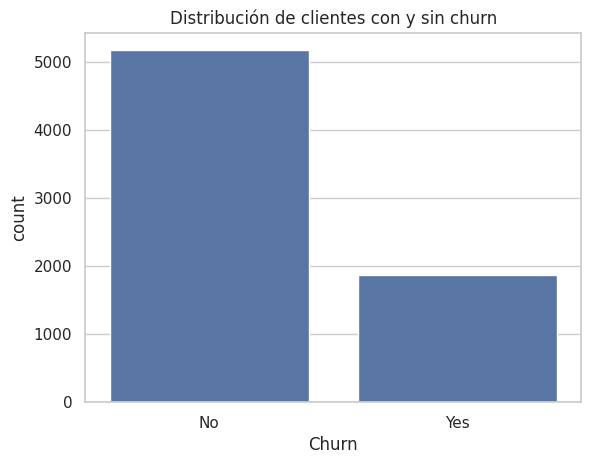

In [8]:
# 📌 5. Ver distribución de clientes que cancelaron vs no cancelaron
churn_rate = df["Churn"].value_counts(normalize=True)
print("Distribución porcentual de churn:")
print(churn_rate)

sns.countplot(x="Churn", data=df)
plt.title("Distribución de clientes con y sin churn")
plt.show()


Análisis de correlación entre variables

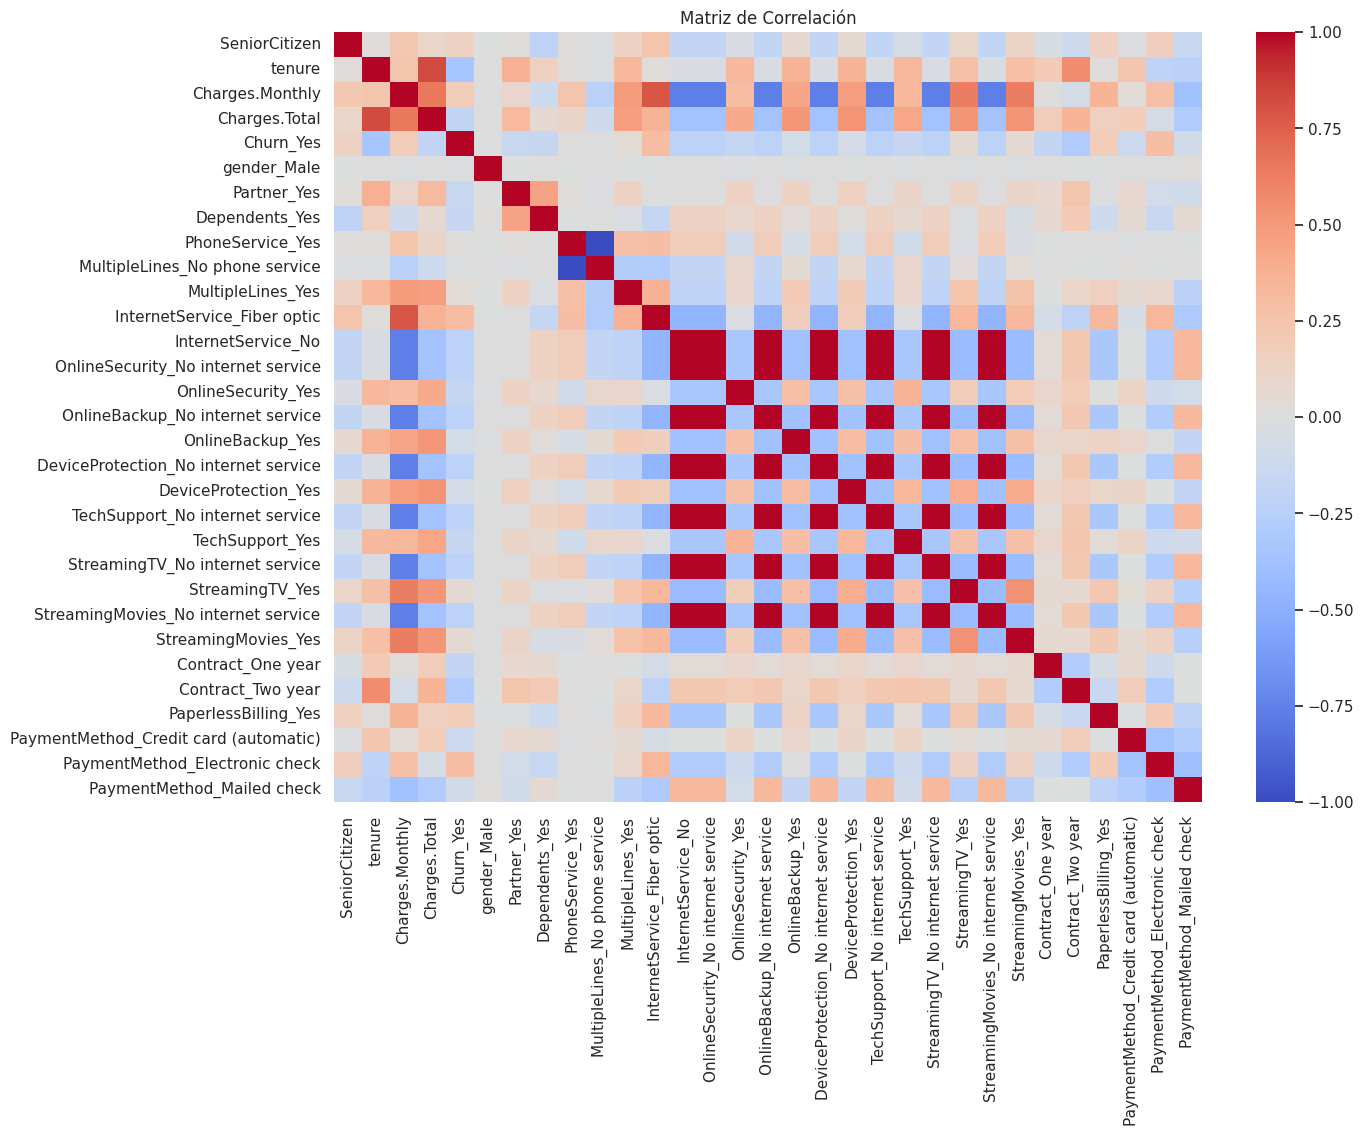

In [9]:
# 📌 6. Matriz de correlación completa (entre variables numéricas y dummies)
plt.figure(figsize=(14, 10))
sns.heatmap(df_encoded.corr(), cmap="coolwarm", center=0)
plt.title("Matriz de Correlación")
plt.show()


In [10]:
# Correlación de todas las variables con la variable objetivo
cor_target = df_encoded.corr()["Churn_Yes"].sort_values(ascending=False)
print(cor_target)


Churn_Yes                                1.000000
InternetService_Fiber optic              0.300949
PaymentMethod_Electronic check           0.294626
Charges.Monthly                          0.189866
PaperlessBilling_Yes                     0.186666
SeniorCitizen                            0.146733
StreamingTV_Yes                          0.062430
StreamingMovies_Yes                      0.060586
MultipleLines_Yes                        0.039343
PhoneService_Yes                         0.012571
gender_Male                             -0.009555
MultipleLines_No phone service          -0.012571
DeviceProtection_Yes                    -0.063452
OnlineBackup_Yes                        -0.080163
PaymentMethod_Mailed check              -0.090061
PaymentMethod_Credit card (automatic)   -0.131085
Partner_Yes                             -0.148546
TechSupport_Yes                         -0.160440
Dependents_Yes                          -0.161384
OnlineSecurity_Yes                      -0.166828


# Visualización de relaciones clave

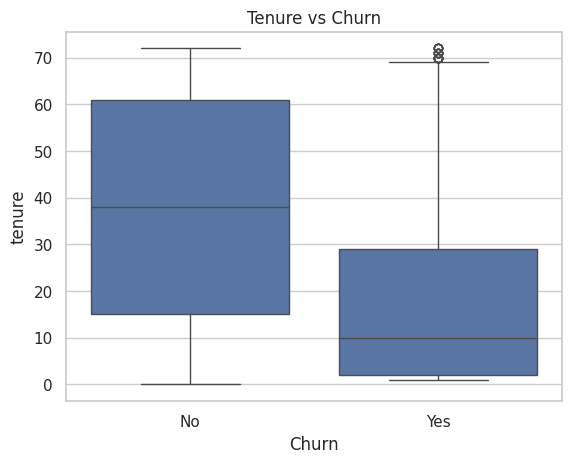

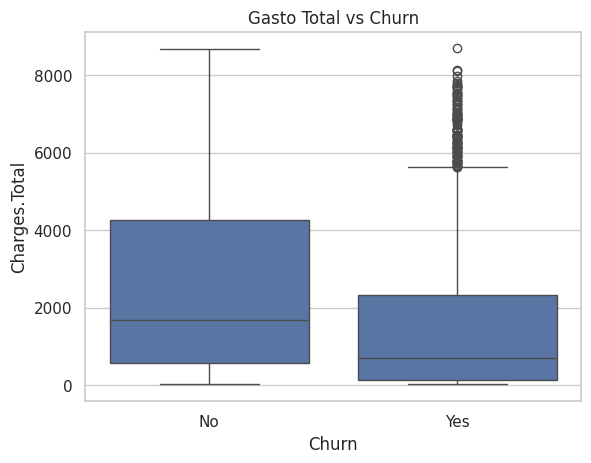

In [11]:
# 📌 7. Tenure vs Churn
sns.boxplot(data=df, x="Churn", y="tenure")
plt.title("Tenure vs Churn")
plt.show()

# 📌 Gasto total vs Churn
sns.boxplot(data=df, x="Churn", y="Charges.Total")
plt.title("Gasto Total vs Churn")
plt.show()


División de datos en entrenamiento y prueba

In [12]:
from sklearn.model_selection import train_test_split

# Variables predictoras y target
X = df_encoded.drop("Churn_Yes", axis=1)
y = df_encoded["Churn_Yes"]

# División del 70% entrenamiento / 30% prueba
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)


Normalización (para modelos que lo requieran)

In [13]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


Entrenamiento de modelos

🔹 Random Forest (no requiere normalización)

In [19]:
# Revisar si hay valores nulos en los datos
print("NaNs en X_train:", pd.DataFrame(X_train_scaled).isnull().sum().sum())
print("NaNs en X:", X.isnull().sum().sum())
print("NaNs por columna:", X.isnull().sum()[X.isnull().sum() > 0])


NaNs en X_train: 9
NaNs en X: 11
NaNs por columna: Charges.Total    11
dtype: int64


In [20]:
from sklearn.impute import SimpleImputer

# Crear imputador que rellene con la media
imputer = SimpleImputer(strategy="mean")

# Aplicar imputación solo a X
X_imputed = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

# Confirmar que no quedan NaNs
print("¿NaNs después de imputar?:", X_imputed.isnull().sum().sum())


¿NaNs después de imputar?: 0


In [29]:
# División 70/30 nuevamente usando los datos imputados
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_imputed, y, test_size=0.3, random_state=42, stratify=y
)

# Normalización (para regresión logística)
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [30]:
# Entrenar modelo de regresión logística con los datos escalados
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(random_state=42, class_weight='balanced')
lr.fit(X_train_scaled, y_train)


LogisticRegression(random_state=42)

In [ ]:
# Entrenar modelo de Random Forest
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(random_state=42, class_weight='balanced')
rf.fit(X_train, y_train)


In [ ]:
# Definir umbral de decisión para Regresión Logística
umbral_optimo = 0.35


Evaluación de modelos

In [31]:
from sklearn.metrics import classification_report, confusion_matrix

# 📍 Regresión Logística (umbral = 0.5)
print("📊 Logistic Regression (umbral=0.5):")
print(classification_report(y_test, lr.predict(X_test_scaled)))
print(confusion_matrix(y_test, lr.predict(X_test_scaled)))

# 📍 Random Forest
print("📊 Random Forest:")
print(classification_report(y_test, rf.predict(X_test)))
print(confusion_matrix(y_test, rf.predict(X_test)))


📊 Logistic Regression:
              precision    recall  f1-score   support

       False       0.85      0.89      0.87      1620
        True       0.63      0.53      0.58       561

    accuracy                           0.80      2181
   macro avg       0.74      0.71      0.72      2181
weighted avg       0.79      0.80      0.80      2181

[[1448  172]
 [ 262  299]]
📊 Random Forest:
              precision    recall  f1-score   support

       False       0.83      0.89      0.86      1620
        True       0.60      0.48      0.53       561

    accuracy                           0.78      2181
   macro avg       0.72      0.68      0.70      2181
weighted avg       0.77      0.78      0.78      2181

[[1444  176]
 [ 294  267]]


### Ajuste de umbral para Regresión Logística


In [ ]:
print("Evaluación con umbral ajustado:")
y_probs = lr.predict_proba(X_test_scaled)[:, 1]
y_pred_umbral = (y_probs >= umbral_optimo).astype(int)
print(classification_report(y_test, y_pred_umbral))
print(confusion_matrix(y_test, y_pred_umbral))


In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score

fpr, tpr, thresholds = roc_curve(y_test, y_probs)
roc_auc = roc_auc_score(y_test, y_probs)
plt.figure()
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC - Regresión Logística')
plt.legend(loc='lower right')
plt.show()


### Entrenamiento con SMOTE


In [ ]:
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler

smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Escalar datos balanceados para Regresión Logística
scaler_smote = StandardScaler()
X_train_smote_scaled = scaler_smote.fit_transform(X_train_smote)
X_test_smote_scaled = scaler_smote.transform(X_test)

lr_smote = LogisticRegression(random_state=42, class_weight='balanced')
lr_smote.fit(X_train_smote_scaled, y_train_smote)

rf_smote = RandomForestClassifier(random_state=42, class_weight='balanced')
rf_smote.fit(X_train_smote, y_train_smote)


In [ ]:
print("Evaluación Logistic Regression con SMOTE:")
print(classification_report(y_test, lr_smote.predict(X_test_smote_scaled)))
print(confusion_matrix(y_test, lr_smote.predict(X_test_smote_scaled)))

print("Evaluación Random Forest con SMOTE:")
print(classification_report(y_test, rf_smote.predict(X_test)))
print(confusion_matrix(y_test, rf_smote.predict(X_test)))
